In [1]:
%pylab inline
from jax.scipy.ndimage import map_coordinates
from constant import * 
import warnings
from jax import jit, partial, random, vmap
from tqdm import tqdm
warnings.filterwarnings("ignore")
np.printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib


In [2]:
nX = Xs.shape[0]
nA = As.shape[0]
Xs.shape, As.shape

((216000, 6), (800, 3))

In [3]:
Vgrid = np.load("Value.npy")

#Define the earning function, which applies for both employment status and 27 econ states
@partial(jit, static_argnums=(0,))
def y(t, x):
    '''
        x = [w,n,m,s,e,o]
        x = [0,1,2,3,4,5]
    '''
    if t <= T_R:
        return detEarning[t] * (1+gGDP[jnp.array(x[3], dtype = jnp.int8)]) * x[4] + (1-x[4]) * welfare
    else:
        return detEarning[-1]
    
#Earning after tax and fixed by transaction in and out from 401k account 
@partial(jit, static_argnums=(0,))
def yAT(t,x):
    yt = y(t, x)
    if t <= T_R:
        # yi portion of the income will be put into the 401k if employed
        return (1-tau_L)*(yt * (1-yi))*x[4] + (1-x[4])*yt
    else:
        # t > T_R, n/discounting amount will be withdraw from the 401k 
        return (1-tau_R)*yt + x[1]*Dn[t]
    
#Define the evolution of the amount in 401k account 
@partial(jit, static_argnums=(0,))
def gn(t, x, r = r_bar):
    if t <= T_R:
        # if the person is employed, then yi portion of his income goes into 401k 
        n_cur = x[1] + y(t, x) * yi * x[4]
    else:
        # t > T_R, n*Dn amount will be withdraw from the 401k 
        n_cur = x[1] - x[1]*Dn[t]
        # the 401 grow as the same rate as the stock 
    return (1+r)*n_cur

#Define the utility function
@jit
def u(c):
    return (jnp.power(c, 1-gamma) - 1)/(1 - gamma)

#Define the bequeath function, which is a function of bequeath wealth
@jit
def uB(tb):
    return B*u(tb)

#Reward function depends on the housing and non-housing consumption
@jit
def R(x,a):
    '''
    Input:
        x = [w,n,m,s,e,o]
        x = [0,1,2,3,4,5]
        a = [c,b,k,h,action]
        a = [0,1,2,3,4]
    '''
    c = a[:,0]
    h = a[:,3]
    C = jnp.power(c, alpha) * jnp.power(h, 1-alpha)
    return u(C)

@partial(jit, static_argnums=(0,))
def feasibleActions(t, x):
    # owner
    sell = As[:,2]
    budget1 = yAT(t,x) + x[0] - (x[2]*(1+rh)-x[2]*Dm[t]) + sell*(H*pt - x[2]*(1+rh) - c_h)
    c = budget1*As[:,0]
    h = jnp.ones(nA)*H*(1+kappa)
    budget2 = budget1*(1-As[:,0])
    k = budget2*As[:,1]
    b = budget2*(1-As[:,1])
    owner_action = jnp.column_stack((c,b,k,h,sell))
    # renter
    buy = As[:,2]*(t<=t_high)
    budget1 = yAT(t,x) + x[0] - buy*(H*pt*0.2 + c_h)
    h = budget1*As[:,0]*(1-alpha)/pr
    c = budget1*As[:,0]*alpha
    budget2 = budget1*(1-As[:,0])
    k = budget2*As[:,1]
    b = budget2*(1-As[:,1])
    renter_action = jnp.column_stack((c,b,k,h,buy))
    actions = x[5]*owner_action + (1-x[5])*renter_action
    return actions

@partial(jit, static_argnums=(0,))
def transition(t,a,x):
    '''
        Input:
            x = [w,n,m,s,e,o]
            x = [0,1,2,3,4,5]
            a = [c,b,k,h,action]
            a = [0,1,2,3,4]
        Output:
            w_next
            n_next
            m_next
            s_next
            e_next
            o_next
            
            prob_next
    '''
    nA = a.shape[0]
    s = jnp.array(x[3], dtype = jnp.int8)
    e = jnp.array(x[4], dtype = jnp.int8)
    # actions taken
    b = a[:,1]
    k = a[:,2]
    action = a[:,4]
    w_next = ((1+r_b[s])*b + jnp.outer(k,(1+r_k)).T).T.flatten().repeat(2)
    n_next = gn(t, x)*jnp.ones(w_next.size)
    s_next = jnp.tile(jnp.arange(nS),nA).repeat(nE)
    e_next = jnp.column_stack((e.repeat(nA*nS),(1-e).repeat(nA*nS))).flatten()
    # job status changing probability and econ state transition probability
    pe = Pe[s, e]
    ps = jnp.tile(Ps[s], nA)
    prob_next = jnp.column_stack(((1-pe)*ps,pe*ps)).flatten()
    
    # owner
    m_next_own = ((1-action)*(x[2]*Dm[t])).repeat(nS*nE)
    o_next_own = (x[5] - action).repeat(nS*nE)
    # renter
    if t <= t_high:
        m_next_rent = (action*H*pt*0.8).repeat(nS*nE)
        o_next_rent = action.repeat(nS*nE)
    else:
        m_next_rent = np.zeros(w_next.size)
        o_next_rent = np.zeros(w_next.size)
    m_next = x[5] * m_next_own + (1-x[5]) * m_next_rent
    o_next = x[5] * o_next_own + (1-x[5]) * o_next_rent   
    return jnp.column_stack((w_next,n_next,m_next,s_next,e_next,o_next,prob_next))

# used to calculate dot product
@jit
def dotProduct(p_next, uBTB):
    return (p_next*uBTB).reshape((p_next.shape[0]//(nS*nE), (nS*nE))).sum(axis = 1)

# define approximation of fit
@jit
def fit(v, xp):
    return map_coordinates(v,jnp.vstack((xp[:,0]/scaleW,
                                                      xp[:,1]/scaleN,
                                                      xp[:,2]/scaleM,
                                                      xp[:,3],
                                                      xp[:,4],
                                                      xp[:,5])),
                                                     order = 1, mode = 'nearest')

@partial(jit, static_argnums=(0,))
def V(t,V_next,x):
    '''
    x = [w,n,m,s,e,o]
    x = [0,1,2,3,4,5]
    xp:
        w_next    0
        n_next    1
        m_next    2
        s_next    3
        e_next    4
        o_next    5
        prob_next 6
    '''
    actions = feasibleActions(t,x)
    xp = transition(t,actions,x)
    # bequeath utility
    TB = xp[:,0]+x[1]*(1+r_bar)+xp[:,5]*(H*pt-x[2]*(1+rh))
    bequeathU = uB(TB)
    if t == T_max-1:
        Q = R(x,actions) + beta * dotProduct(xp[:,6], bequeathU)
    else:
        Q = R(x,actions) + beta * dotProduct(xp[:,6], Pa[t]*fit(V_next, xp) + (1-Pa[t])*bequeathU)
    Q = jnp.nan_to_num(Q, nan = -100)
    v = Q.max()
    cbkha = actions[Q.argmax()]
    return v, cbkha.reshape((1,-1))

In [4]:
num = 10000
'''
    x = [w,n,m,s,e,o]
    x = [5,0,0,0,0,0]
'''
from jax import random

def simulation(key):
    x = [5, 0, 0, 0, 0, 0]
    path = []
    move = []
    for t in range(T_min, T_max-1):
        _, key = random.split(key)
        _,a = V(t,Vgrid[:,:,:,:,:,:,t+1],x)
        xp = transition(t,a,x)
        p = xp[:,-1]
        x_next = xp[:,:-1]
        x = x_next[random.choice(a = nS*nE, p=p, key = key)]
        path.append(x)
        move.append(a[0])
    return jnp.array(path), jnp.array(move)

In [5]:
%%time
# simulation part 
keys = vmap(random.PRNGKey)(jnp.arange(num))
Paths, Moves = vmap(simulation)(keys)

CPU times: user 1h 37min 50s, sys: 28min 47s, total: 2h 6min 37s
Wall time: 8min 19s


In [6]:
# x = [w,n,m,s,e,o]
# x = [0,1,2,3,4,5]
ws = Paths[:,:,0].T
ns = Paths[:,:,1].T
ms = Paths[:,:,2].T
ss = Paths[:,:,3].T
es = Paths[:,:,4].T
os = Paths[:,:,5].T
cs = Moves[:,:,0].T
bs = Moves[:,:,1].T
ks = Moves[:,:,2].T
hs = Moves[:,:,3].T

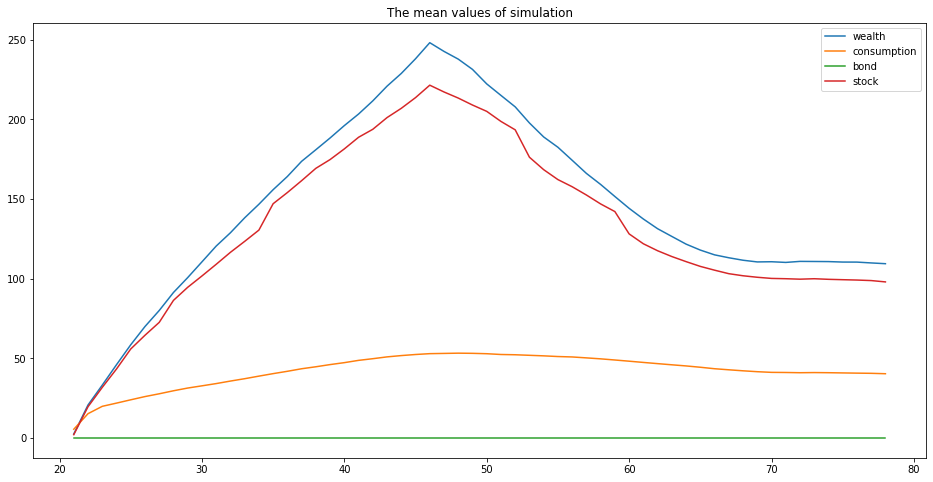

In [7]:
plt.figure(figsize = [16,8])
plt.title("The mean values of simulation")
plt.plot(range(21, T_max-1 + 20),jnp.median(ws,axis = 1)[:-1], label = "wealth")
plt.plot(range(21, T_max-1 + 20),jnp.median(cs,axis = 1)[:-1], label = "consumption")
plt.plot(range(21, T_max-1 + 20),jnp.median(bs,axis = 1)[:-1], label = "bond")
plt.plot(range(21, T_max-1 + 20),jnp.median(ks,axis = 1)[:-1], label = "stock")
# plt.plot(range(21, T_max-1 + 20),jnp.median(os*H*pt - ms+ws,axis = 1)[:-1], label = "Home equity + wealth")
# plt.plot((hs*pr).mean(axis = 1)[:-1], label = "housing")
plt.legend()

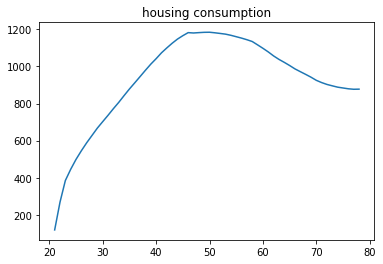

In [8]:
plt.title("housing consumption")
plt.plot(range(21, T_max-1 + 20),(hs).mean(axis = 1)[:-1], label = "housing")

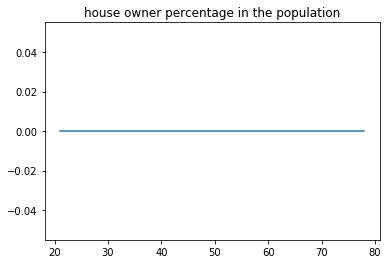

In [9]:
plt.title("house owner percentage in the population")
plt.plot(range(21, T_max-1 + 20),(os).mean(axis = 1)[:-1], label = "owning")

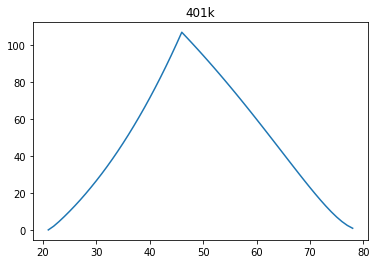

In [10]:
plt.title("401k")
plt.plot(range(21, T_max-1 + 20),(ns).mean(axis = 1)[:-1], label = "housing")